In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.special import rel_entr
from envs.forked_riverswim import ForkedRiverSwim
from envs.riverswim import RiverSwim
from typing import Sequence, Dict, Tuple, Union, Literal, NamedTuple
from itertools import product
from numpy.typing import NDArray
import torch
import lzma
import pyximport
_ = pyximport.install(setup_args={"include_dirs":np.get_include()}, reload_support=True)
from utils.cutils import policy_evaluation
from utils.utils import Results, policy_iteration
from utils.new_mdp_description import NewMDPDescription
from scipy.stats import t
from make_agent import AgentType
from simulation_parameters import EnvType, SimulationParameters
from main_new import SequencedResults
import seaborn as sns
import pandas as pd
def TV(p,q):
    return np.sum(np.abs(p-q), -1) * 0.5

def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = t.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

    
compute_dist_omega = lambda x,y: TV(x,y)
compute_dist_value = lambda V, mdp: np.linalg.norm(V -mdp.V_greedy[np.newaxis, np.newaxis], axis=-1)

/home/alessior/anaconda3/envs/exploration-maze/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TITLE_SIZE = 22
LEGEND_SIZE = 15
TICK_SIZE = 14
AXIS_TITLE = 22
XAXIS_LABEL = 22
AXIS_LABEL = 22
FONT_SIZE = 14

rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        r'\usepackage{amsmath}',
    ]
}
plt.rcParams.update(rc_parameters)

In [3]:
lengths = [
    (5, EnvType.RIVERSWIM),
    (3, EnvType.FORKED_RIVERSWIM),
    (10, EnvType.RIVERSWIM),
    (5, EnvType.FORKED_RIVERSWIM),
    (20, EnvType.RIVERSWIM),
    (10, EnvType.FORKED_RIVERSWIM),
    (30, EnvType.RIVERSWIM),
    (15, EnvType.FORKED_RIVERSWIM),
    (50, EnvType.RIVERSWIM),
    (25, EnvType.FORKED_RIVERSWIM)
    ]
agents = [AgentType.Q_UCB, AgentType.BAYES_MFBPI, AgentType.FORCED_MFBPI, AgentType.MDP_NAS, AgentType.PSRL] #AgentType.Q_UCB,  , AgentType.FORCED_MFBPI]

data: Dict[Tuple[int, EnvType, AgentType],  SequencedResults] = {}
for env_type, agent in product(lengths, agents):
    length, env = env_type
    data[(length, env, agent)] = None
    
    print(f"> Opening {env.value}/{agent.value}/{length}")
    with lzma.open(f'data/10runs/{env.value}/{agent.value}_{length}.pkl.lzma', 'rb') as f:
        res  = pickle.load(f)
        data[(length, env, agent)] = res



> Opening Riverswim/Q-UCB/5
> Opening Riverswim/Bayes-MFBPI/5
> Opening Riverswim/Forced-MFBPI/5
> Opening Riverswim/MDP-NaS/5
> Opening Riverswim/PSRL/5
> Opening ForkedRiverswim/Q-UCB/3
> Opening ForkedRiverswim/Bayes-MFBPI/3
> Opening ForkedRiverswim/Forced-MFBPI/3
> Opening ForkedRiverswim/MDP-NaS/3
> Opening ForkedRiverswim/PSRL/3
> Opening Riverswim/Q-UCB/10
> Opening Riverswim/Bayes-MFBPI/10
> Opening Riverswim/Forced-MFBPI/10
> Opening Riverswim/MDP-NaS/10
> Opening Riverswim/PSRL/10
> Opening ForkedRiverswim/Q-UCB/5
> Opening ForkedRiverswim/Bayes-MFBPI/5
> Opening ForkedRiverswim/Forced-MFBPI/5
> Opening ForkedRiverswim/MDP-NaS/5
> Opening ForkedRiverswim/PSRL/5
> Opening Riverswim/Q-UCB/20
> Opening Riverswim/Bayes-MFBPI/20
> Opening Riverswim/Forced-MFBPI/20
> Opening Riverswim/MDP-NaS/20
> Opening Riverswim/PSRL/20
> Opening ForkedRiverswim/Q-UCB/10
> Opening ForkedRiverswim/Bayes-MFBPI/10
> Opening ForkedRiverswim/Forced-MFBPI/10
> Opening ForkedRiverswim/MDP-NaS/10
> Ope

In [4]:
labels = {
    AgentType.PSRL: 'PSRL',
    AgentType.Q_UCB: 'Q-UCB',
    AgentType.MDP_NAS: 'MDP-NaS',
    AgentType.BAYES_MFBPI: 'Bootstrapped MF-BPI',
    AgentType.FORCED_MFBPI: 'Forced MF-BPI'
}

def find_first_below_threshold(matrix, threshold=0.05):
    # Create a boolean mask of elements less than the threshold
    mask = matrix < threshold
    
    # For each row, find the first occurrence of a value below the threshold and return the index
    indices = np.array([np.argmax(row) if np.any(row) else len(row) for row in mask])
    
    return indices

df = pd.DataFrame({
    'N': [],
    'Environment': [],
    'Agent': [],
    't_hit': []
})
for length, env_type in lengths:
    if env_type == EnvType.RIVERSWIM:
        env = RiverSwim(length)
    else:
        env = ForkedRiverSwim(length)
    Vgreedy, _, _ =policy_iteration(0.99, env.transitions, env.rewards)
    for agent in agents:
        x = data[(length, env_type, agent)].dist_value_infinity / np.max(Vgreedy)
        idxs =  1 - x[:,-1] #find_first_below_threshold(x)* data[(length, env_type, agent)].simulation_parameters.frequency_evaluation
        for i in idxs:
            df.loc[len(df)] = [length, env_type.value, labels[agent], i]

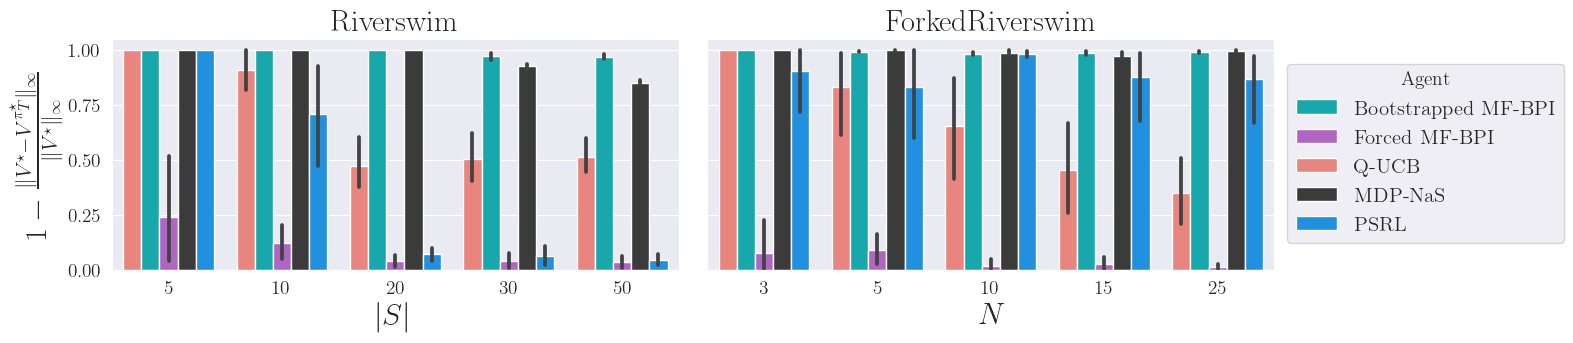

In [5]:
TITLE_SIZE = 22
LEGEND_SIZE = 15
TICK_SIZE = 14
AXIS_TITLE = 22
XAXIS_LABEL = 22
AXIS_LABEL = 22
FONT_SIZE = 14

rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        r'\usepackage{amsmath}',
    ]
}
plt.rcParams.update(rc_parameters)
sns.set_style("darkgrid", rc=rc_parameters)
colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']

filtered_df = df[df['Agent'] != 'Q-Learning']
unique_agents = filtered_df['Agent'].unique()

color_dict = {agent: color for agent, color in zip(unique_agents, colors)}



fig, axes = plt.subplots(1,2, sharey=True, figsize=(15, 3),)
for ax_id, environment in enumerate([EnvType.RIVERSWIM.value, EnvType.FORKED_RIVERSWIM.value]):
    env_data = filtered_df[filtered_df['Environment'] == environment]
    sns.barplot(x="N", y="t_hit", hue="Agent", data=env_data, palette=color_dict, ax=axes[ax_id])
    axes[ax_id].get_legend().remove() 
    axes[ax_id].set_xlabel('$|S|$' if environment == EnvType.RIVERSWIM.value else '$N$')
    axes[ax_id].set_title(r'\rm{' + environment + '}')

axes[1].set_ylabel('')
axes[0].set_ylabel(r"$1-\frac{\|V^\star - V^{\pi_{T}^\star}\|_\infty}{\|V^\star\|_\infty}$")
plt.subplots_adjust(wspace=0.05)
handles, labels = axes[0].get_legend_handles_labels()




# Manually reorder the handles and labels
ordered_handles = [handles[1], handles[2], handles[0], handles[3], handles[4]]  # Change the order as desired
ordered_labels = [labels[1], labels[2], labels[0], labels[3], labels[4]]  # Change the order as desired

fig.legend(ordered_handles, ordered_labels, loc='center right', bbox_to_anchor=(1.1, 0.5), title='Agent')




plt.savefig('figures/results.pdf', bbox_inches='tight')

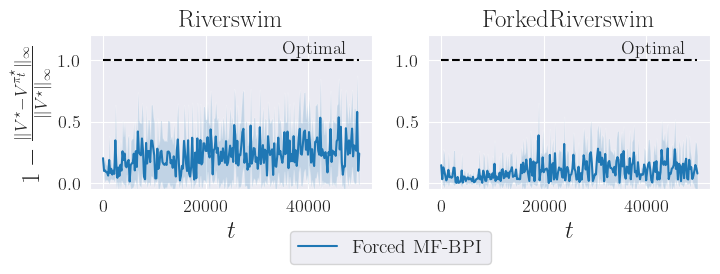

In [35]:
TITLE_SIZE = 18
LEGEND_SIZE = 14
TICK_SIZE = 13
AXIS_TITLE = 18
AXIS_LABEL = 18
FONT_SIZE = 13

rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        r'\usepackage{amsmath}',
    ]
}
plt.rcParams.update(rc_parameters)

sns.set_style("darkgrid", rc=rc_parameters)

fig, ax = plt.subplots(1, 2, figsize=(8,2))

axis_id = 0
for length, env_type in [(5, EnvType.RIVERSWIM), (3, EnvType.FORKED_RIVERSWIM)]:
    if env_type == EnvType.RIVERSWIM:
        env = RiverSwim(length)
    else:
        env = ForkedRiverSwim(length)
    Vgreedy, _, _ =policy_iteration(0.99, env.transitions, env.rewards)
    
    agent = AgentType.FORCED_MFBPI
    parameters=  data[(length, env_type, agent)].simulation_parameters
    x = range(0, parameters.horizon + 1, parameters.frequency_evaluation)

    df = pd.DataFrame(1- data[(length, env_type, agent)].dist_value_infinity / np.max(Vgreedy))
    df = df.stack().reset_index()
    df.columns = ['Run', 't', 'Value']
    alpha = 0.05  # Adjust this for the desired confidence level (e.g., 0.05 for 95% confidence intervals)
    grouped_data = df.groupby('t')['Value'].agg(['mean', 'sem'])
    grouped_data['lower'] = grouped_data['mean'] - t.ppf(1 - alpha/2, len(data)-1) * grouped_data['sem']
    grouped_data['upper'] = grouped_data['mean'] + t.ppf(1 - alpha/2, len(data)-1) * grouped_data['sem']
    grouped_data.reset_index(inplace=True)
    ax[axis_id].plot(x, grouped_data['mean'],label=agent.value)#, linestyle=linestyle[agent], color=colors[agent_id])
    ax[axis_id].fill_between(x, grouped_data['lower'], grouped_data['upper'], alpha=0.2)#,  color=colors[agent_id])
    ax[axis_id].plot(x, np.ones(len(x)), 'k--')
    ax[axis_id].text(35000, 1.05, 'Optimal')
    ax[axis_id].set_title(r'\textrm{'+ env_type.value + '}')
    ax[axis_id].set_xlabel(r'$t$')
    ax[axis_id].set_ylim(-0.05, 1.2)
    axis_id += 1

# ax[0,0].legend()
ax[0].set_ylabel(r'$1-\frac{\|V^\star - V^{\pi_t^\star}\|_\infty}{\|V^\star\|_\infty}$')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, ['Forced MF-BPI'], loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=True)

# plt.subplots_adjust(bottom=0)  # Adjust the bottom margin to make room for the legend

plt.savefig('figures/forced_generative.pdf', bbox_inches='tight')
plt.show()


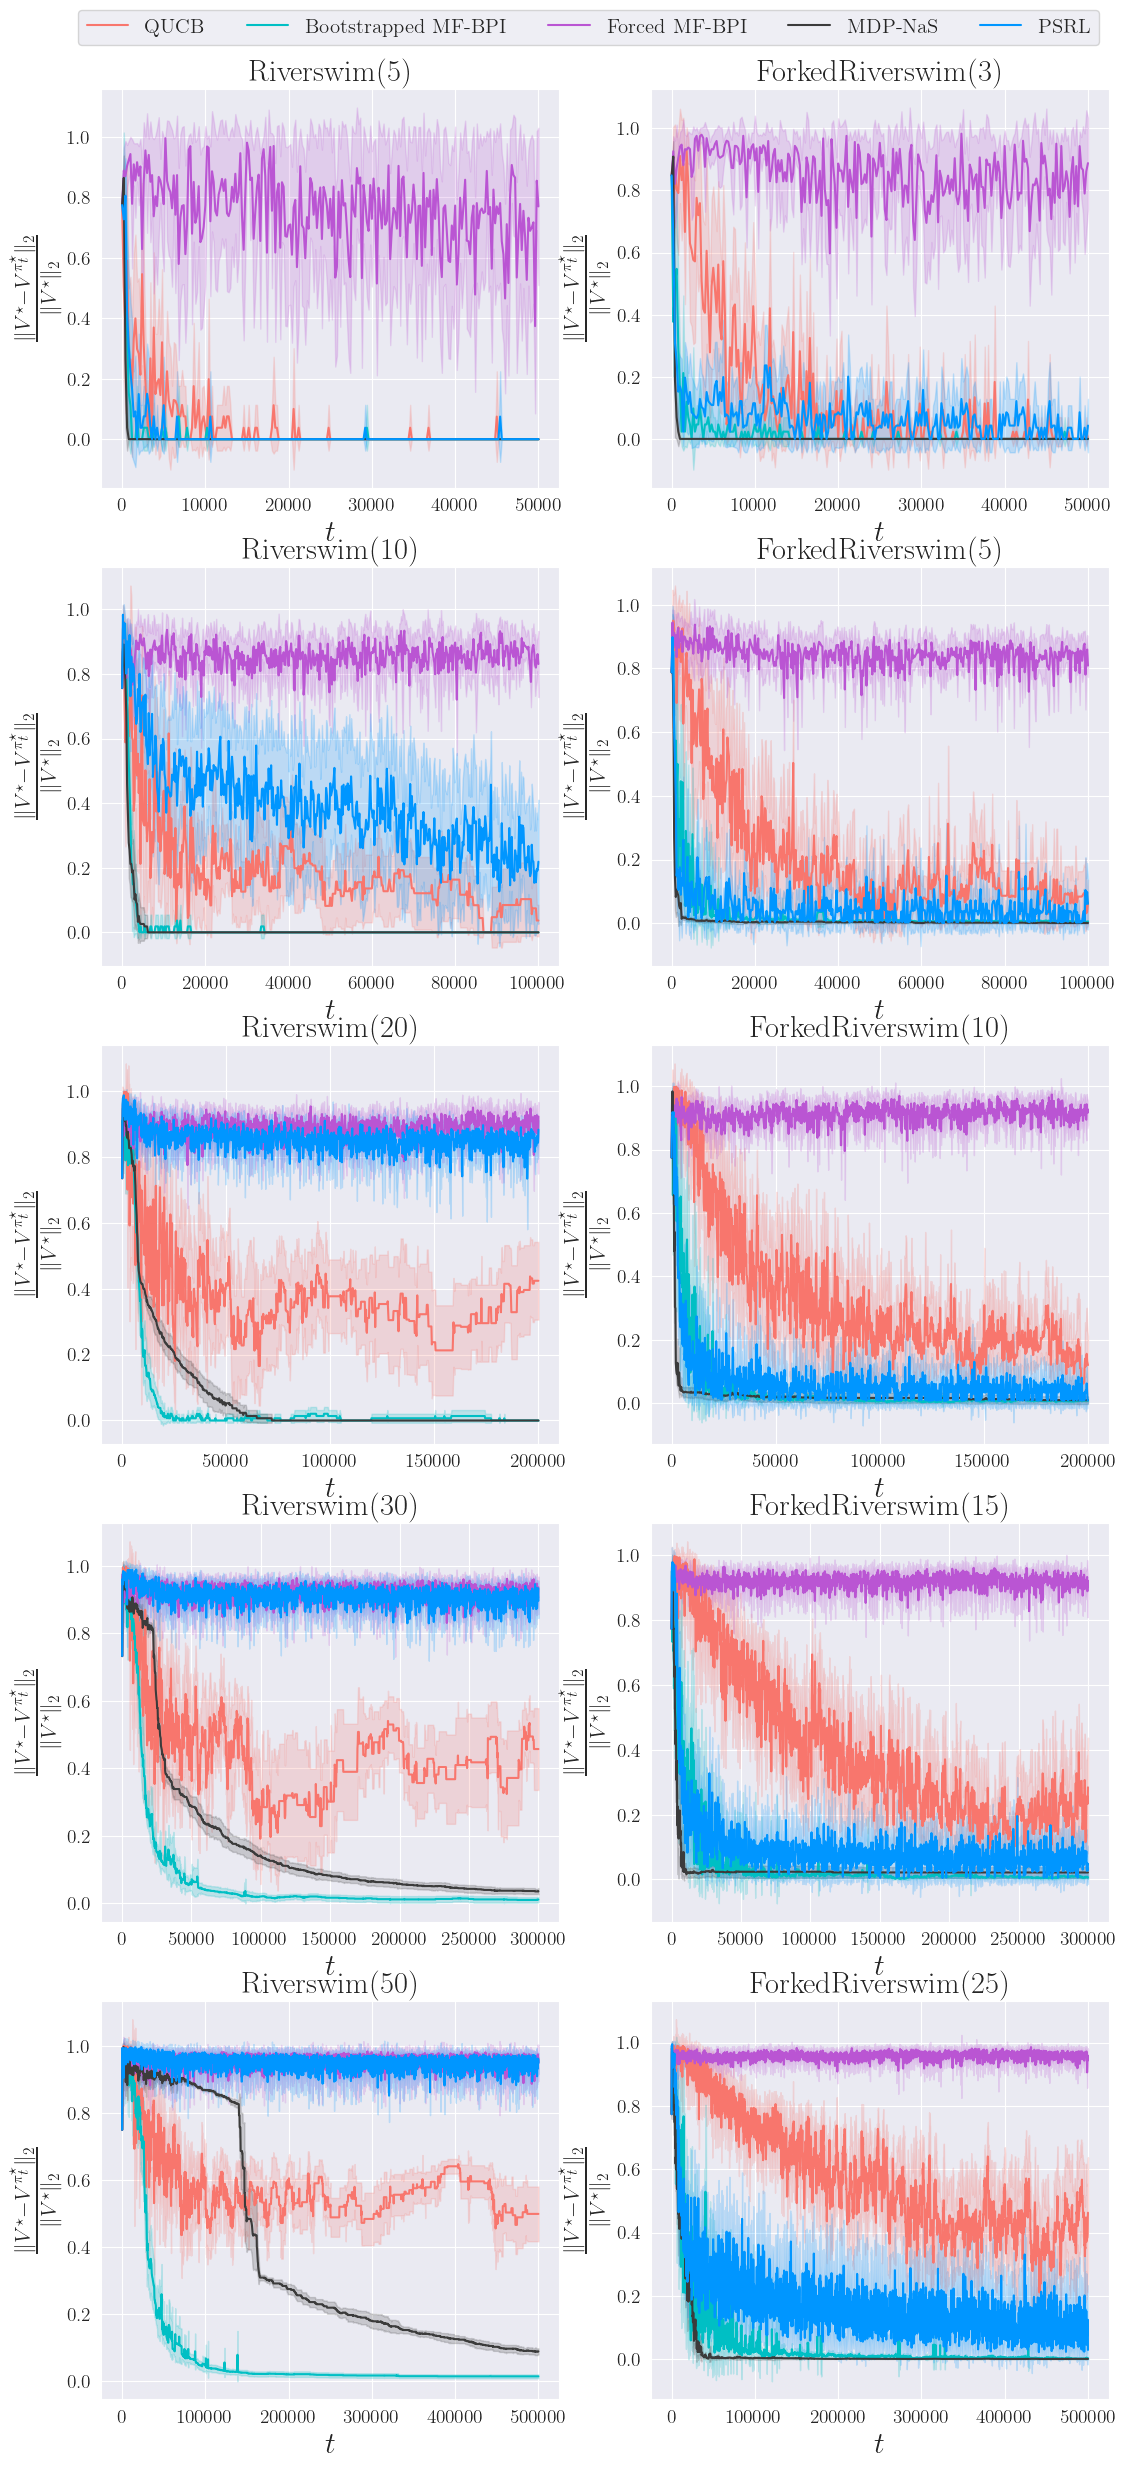

: 

In [37]:
TITLE_SIZE = 22
LEGEND_SIZE = 15
TICK_SIZE = 14
AXIS_TITLE = 22
XAXIS_LABEL = 22
AXIS_LABEL = 22
FONT_SIZE = 14

rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        r'\usepackage{amsmath}',
    ]
}
plt.rcParams.update(rc_parameters)
sns.set_style("darkgrid", rc=rc_parameters)

fig, ax = plt.subplots(5, 2 ,figsize=(13,30))
colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']
labels = {
    AgentType.Q_UCB: "QUCB", 
    AgentType.Q_LEARNING: "Q-learning", 
    AgentType.BAYES_MFBPI: "Bootstrapped MF-BPI",
    AgentType.FORCED_MFBPI: "Forced MF-BPI",
    AgentType.PSRL: "PSRL",
    AgentType.MDP_NAS: "MDP-NaS"
}
linestyle = {
    AgentType.Q_UCB: "solid", 
    AgentType.Q_LEARNING: "solid", 
    AgentType.BAYES_MFBPI: "solid",
    AgentType.FORCED_MFBPI: "solid",
    AgentType.PSRL: "solid",
    AgentType.MDP_NAS: "solid",
}

id_l = 0
for length, env_type in lengths:
    if env_type == EnvType.RIVERSWIM:
        env = RiverSwim(length)
    else:
        env = ForkedRiverSwim(length)
    Vgreedy, _, _ =policy_iteration(0.99, env.transitions, env.rewards)
    
    id_e = 0 if env_type == EnvType.RIVERSWIM else 1

    if env_type == EnvType.RIVERSWIM:
        id_l = 0 if length == 5 else 1 if length == 10 else 2 if length == 20 else 3 if length == 30 else 4
    else:
        id_l = 0  if length == 3 else 1 if length == 5 else 2 if length == 10 else 3 if length == 15 else 4
    for agent_id,  agent in enumerate(agents):
        parameters=  data[(length, env_type, agent)].simulation_parameters
        x = range(0, parameters.horizon + 1, parameters.frequency_evaluation)

        df = pd.DataFrame(data[(length, env_type, agent)].dist_value / np.linalg.norm(Vgreedy))
        df = df.stack().reset_index()
        df.columns = ['Run', 't', 'Value']
        alpha = 0.05  # Adjust this for the desired confidence level (e.g., 0.05 for 95% confidence intervals)
        grouped_data = df.groupby('t')['Value'].agg(['mean', 'sem'])
        grouped_data['lower'] = grouped_data['mean'] - t.ppf(1 - alpha/2, len(data)-1) * grouped_data['sem']
        grouped_data['upper'] = grouped_data['mean'] + t.ppf(1 - alpha/2, len(data)-1) * grouped_data['sem']
        grouped_data.reset_index(inplace=True)
        ax[id_l, id_e].plot(grouped_data['t'] * parameters.frequency_evaluation, grouped_data['mean'],label=labels[agent], linestyle=linestyle[agent], color=colors[agent_id])
        ax[id_l, id_e].fill_between(grouped_data['t'] * parameters.frequency_evaluation, grouped_data['lower'], grouped_data['upper'], alpha=0.2,  color=colors[agent_id])

        #mu, ce = CE(data[(length, env_type, agent)].dist_value / np.linalg.norm(Vgreedy))
        #ax[id_l, id_e].plot(x, mu, label=labels[agent], linestyle=linestyle[agent], color=colors[agent_id])
        #ax[id_l, id_e].fill_between(x, mu-ce, mu+ce, alpha=0.2)
        #sns.lineplot(x='t', y='Value', data=df, errorbar=('ci', 95))
    #ax[id_l, id_e].grid()
    #if id_l == 0:
    ax[id_l, id_e].set_title(r'\textrm{' + f'{env_type.value}({length})' + '}')

    ax[id_l, id_e].set_ylabel(r'$\frac{\|V^\star - V^{\pi_t^\star}\|_2}{\|V^\star\|_2}$')

    # if id_l == 4:
    ax[id_l, id_e].set_xlabel('$t$')

# plt.subplots_adjust(wspace=0.05)
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, .91), frameon=True, ncols = len(handles))

plt.savefig('figures/full.pdf', bbox_inches='tight')
plt.show()
